In [0]:
# collab to get connected with drive to save data (optional but beneficial)
from google.colab import drive
drive.mount('/content/gdrive')

In [20]:
root_drive="data"

^C


# A preprocess function to convert the Images to white Bg and also greyscale conversion

In [0]:
# # folder converter python program
# import os
# from random import randrange
# from PIL import Image

# currentPosition=os.path.join(root_drive)
# files=os.listdir(currentPosition)
# try:
#     os.mkdir(os.path.join(currentPosition,"train"))
#     os.mkdir(os.path.join(currentPosition,"valid"))
# except:
#     print("Duplicate")

# for i in files:
#     trainFolder=os.path.join(currentPosition,"train",i)
#     testFolder=os.path.join(currentPosition,"valid",i)
#     os.mkdir(trainFolder)
#     os.mkdir(testFolder)
#     currentFolder=os.path.join(currentPosition,i)
#     datasets=os.listdir(currentFolder)

#     for i in range(int((20*len(datasets))/100)):
#         source=randrange(len(datasets))
#         img=Image.open(os.path.join(currentFolder,datasets[source]));
#         trans2white=Image.new("RGB",img.size,(255,255,255))
#         trans2white.paste(img,mask=img.split()[3])
#         trans2white.convert("L").save(os.path.join(testFolder,datasets[source]),"PNG")
#         os.remove(os.path.join(currentFolder,datasets[source]))
#         datasets.pop(source)
#     for k in datasets:
#         img=Image.open(os.path.join(currentFolder,k));
#         trans2white=Image.new("RGB",img.size,(255,255,255))
#         trans2white.paste(img,mask=img.split()[3])
#         trans2white=trans2white.convert("L")
#         trans2white.save(os.path.join(trainFolder,k),"PNG")
#         os.remove(os.path.join(currentFolder,k))    

# for i in os.listdir("/content/gdrive/My Drive/Colab Notebooks/malayalam-ocr/data")[:-2]:
#   os.rmdir(os.path.join("/content/gdrive/My Drive/Colab Notebooks/malayalam-ocr/data",i))

In [0]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Adding all the transforms

In [0]:
transformations=transforms.Compose([transforms.Grayscale(1),
                                    transforms.Resize(32),
                                    transforms.ToTensor(),
                                   transforms.Normalize([0.5], [0.5])
                                     ])

In [0]:
train_set=datasets.ImageFolder(root_drive+"/train/",transform=transformations)
val_set=datasets.ImageFolder(root_drive+"/valid/",transform=transformations)

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
labels=labels.numpy()


#Printing a train data

Text(0.5, 1.0, '1')

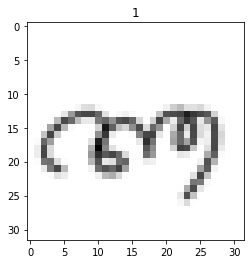

In [0]:
images=np.squeeze(images)
plt.imshow(images[0],cmap="gray")
plt.title(labels[0])


# Defining the network model

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    # conv layer on 1->16->32->64
    self.conv1=nn.Conv2d(1,16,3,padding=1)
    self.conv2=nn.Conv2d(16,32,3,padding=1)
    self.conv3=nn.Conv2d(32,64,3,padding=1)
    # adding a pooling layer
    self.pool=nn.MaxPool2d(2,2)
    # linear layer 
    # output volume (W-F+2P)/s+1
    self.fc1=nn.Linear(64*4*4,500)
    self.fc2=nn.Linear(500,48)
    #adding dropout layer
    self.dropout=nn.Dropout(0.25)
  
  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    #flatten for FC network 
    x=x.view(-1,64*4*4)
    x=self.dropout(x)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.fc2(x)
    return x


# Loss Function

In [0]:
train_on_gpu= torch.cuda.is_available()

model = Net()

if train_on_gpu:
    model.cuda()

print(train_on_gpu)

criterion = nn.CrossEntropyLoss()

optimizer=optim.SGD(model.parameters(),lr=0.01)

True


# Train Function

In [0]:
def train(epochs,model,valid_loss_min):
  for epoch in range(1,epochs+1):
    train_loss=0.0
    valid_loss=0.0

    model.train()

    for data, target in train_loader:
      # moving to cuda
      if train_on_gpu:
        data,target=data.cuda(),target.cuda()
      # clearence gradients
      optimizer.zero_grad()
      # getting output
      output=model(data)
      # getting loss
      loss = criterion(output,target)
      # backpropagation
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*data.size(0)
    
    model.eval()

    for data,target in val_loader:
      if train_on_gpu:
        data,target=data.cuda(),target.cuda()
      
      output=model(data)
      loss=criterion(output,target)

      valid_loss+=loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)

    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss<=valid_loss_min:
       print('Model Save ({:.6f} --> {:.6f})'.format(valid_loss_min,valid_loss))
       torch.save({
           "model":model.state_dict(),
           "valid_loss_min":valid_loss
       },os.path.join(root_drive,"save",'malayalamOCR.pt'))
       valid_loss_min=valid_loss


In [0]:
loadFileName=os.path.join(root_drive,"save",'malayalamOCR.pt')

if loadFileName:
  savedState=torch.load(loadFileName)
  modelDict=savedState["model"]
  valid_loss_min=savedState["valid_loss_min"]

epochs=30
if loadFileName:
  model.load_state_dict(modelDict)
train(epochs,model,valid_loss_min)



Epoch: 1 	 Training Loss: 0.385052 	 Validation Loss: 0.466310
Model Save (0.476871 --> 0.466310)
Epoch: 2 	 Training Loss: 0.380742 	 Validation Loss: 0.510144
Epoch: 3 	 Training Loss: 0.363094 	 Validation Loss: 0.476563
Epoch: 4 	 Training Loss: 0.337165 	 Validation Loss: 0.486201
Epoch: 5 	 Training Loss: 0.337628 	 Validation Loss: 0.487221
Epoch: 6 	 Training Loss: 0.313422 	 Validation Loss: 0.497166
Epoch: 7 	 Training Loss: 0.306858 	 Validation Loss: 0.466344
Epoch: 8 	 Training Loss: 0.312759 	 Validation Loss: 0.445138
Model Save (0.466310 --> 0.445138)
Epoch: 9 	 Training Loss: 0.275476 	 Validation Loss: 0.439825
Model Save (0.445138 --> 0.439825)
Epoch: 10 	 Training Loss: 0.276107 	 Validation Loss: 0.442553
Epoch: 11 	 Training Loss: 0.272700 	 Validation Loss: 0.470670
Epoch: 12 	 Training Loss: 0.263103 	 Validation Loss: 0.455390
Epoch: 13 	 Training Loss: 0.257030 	 Validation Loss: 0.463782
Epoch: 14 	 Training Loss: 0.252921 	 Validation Loss: 0.457545
Epoch: 1

# Checking our final model 

In [0]:
loadFileName=None
# if ur not startiong from scratch remove above line and uncomment below
#loadFileName=os.path.join(root_drive,"save",'malayalamOCR.pt')

if loadFileName:
  savedState=torch.load(loadFileName)
  modelDict=savedState["model"]
  valid_loss_min=savedState["valid_loss_min"]

epochs=30
if loadFileName:
  model.load_state_dict(modelDict)

  # just to get the feel ;)
  malayalam_alphabets=["Aa","Aaaaaaaaa","Ee","Vu"]

Text(0.5, 1.0, 'Vu')

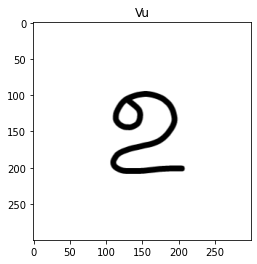

In [0]:
model.eval()
image = Image.open("./alphabet_test2.png")
original_image=image
image=transformations(image)
if train_on_gpu:
        image=image.cuda()
image = image.unsqueeze(0)
output=model(image)
_, preds_tensor = torch.max(output, 1)
pred = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

plt.imshow(original_image,cmap="gray")
plt.title(malayalam_alphabets[pred])